In [166]:
import pandas as pd
import matplotlib.pyplot as plt

from textblob import TextBlob
import seaborn as sns


import re  
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer


nltk.download('wordnet')
nltk.download('vader_lexicon')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/markhurtado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/markhurtado/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [167]:
df = pd.read_csv('../data/judge_1377884607_tweet_product_company.csv')

In [168]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [169]:
df.rename(columns = {"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace = True)

In [170]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [171]:
df['emotion'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: emotion, dtype: int64

In [172]:
df = df.drop(df[df['emotion'] == "I can't tell"].index)

In [173]:
df['emotion'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
Name: emotion, dtype: int64

In [174]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               906
Apple                              638
iPad or iPhone App                 451
Google                             411
iPhone                             287
Other Google product or service    281
Android App                         78
Android                             74
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [175]:
df['emotion_in_tweet_is_directed_at'].isna().sum()

5410

In [151]:
df.drop(columns = 'emotion_in_tweet_is_directed_at', inplace = True)

In [152]:
df.dropna(inplace = True)

In [153]:
df.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [154]:
def count_chars(text):
    return len(text)
    

In [155]:
def count_words(text):
    return len(text.split())

In [156]:
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

In [157]:
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

In [158]:
def count_words_in_quotes(text):
    x = re.findall("'.'|''.'", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

In [159]:
def count_sent(text):
    return len(nltk.sent_tokenize(text))

In [160]:
def count_unique_words(text):
    return len(set(text.split()))

In [161]:
def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x) 

In [162]:
def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

In [163]:
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

In [164]:
df['char_count'] = df["tweet_text"].apply(lambda x:count_chars(x))
df['word_count'] = df["tweet_text"].apply(lambda x:count_words(x))
df['sent_count'] = df["tweet_text"].apply(lambda x:count_sent(x))
df['capital_char_count'] = df["tweet_text"].apply(lambda x:count_capital_chars(x))
df['capital_word_count'] = df["tweet_text"].apply(lambda x:count_capital_words(x))
df['quoted_word_count'] = df["tweet_text"].apply(lambda x:count_words_in_quotes(x))
df['stopword_count'] = df["tweet_text"].apply(lambda x:count_stopwords(x))
df['unique_word_count'] = df["tweet_text"].apply(lambda x:count_unique_words(x))
df['htag_count'] = df["tweet_text"].apply(lambda x:count_htags(x))
df['mention_count'] = df["tweet_text"].apply(lambda x:count_mentions(x))
df['avg_wordlength'] = df['char_count']/df['word_count']
df['avg_sentlength'] = df['word_count']/df['sent_count']
df['unique_vs_words'] = df['unique_word_count']/df['word_count']
df['stopwords_vs_words'] = df['stopword_count']/df['word_count']

In [165]:
df

,tweet_text,emotion,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,127,23,5,15,4,0,7,21,0,1,5.521739,4.600000,0.913043,0.304348
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,139,22,3,10,1,0,7,22,0,0,6.318182,7.333333,1.000000,0.318182
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,79,15,2,7,1,0,6,15,0,0,5.266667,7.500000,1.000000,0.400000
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,82,15,2,2,1,0,5,12,0,0,5.466667,7.500000,0.800000,0.333333
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,131,17,1,14,1,0,1,17,0,0,7.705882,17.000000,1.000000,0.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8716,Ipad everywhere. #SXSW {link},Positive emotion,29,4,2,5,1,0,0,4,0,0,7.250000,2.000000,1.000000,0.000000
8717,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product,125,18,1,4,1,0,2,18,0,0,6.944444,18.000000,1.000000,0.111111
8718,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product,145,19,3,9,2,0,2,19,0,0,7.631579,6.333333,1.000000,0.105263
8719,Some Verizon iPhone customers complained their...,No emotion toward brand or product,140,23,2,10,1,0,7,23,0,0,6.086957,11.500000,1.000000,0.304348


In [121]:
# the following code is courtesy of Dr. Praveen Gowtham
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')
    stop_words += ['rt', 'link', 'apple', 'google', 'ipad', 'quot', 'iphone', 'app', 'android']

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return tweet_norm.split(" ")

In [122]:
df['tweet_tokens'] = df['tweet_text'].apply(process_tweet, args = [5])

In [123]:
df = df.drop(df[df['tweet_tokens'] == ""].index)

In [124]:
df

,tweet_text,emotion,tweet_tokens,sentiment,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[hrs, tweet, dead, need, upgrade, plugin, stat...",0,127,23,5,15,4,0,7,21,0,1,{'! count': 1},5.521739,4.600000,0.913043,0.304348
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[know, awesome, likely, appreciate, design, al...",2,139,22,3,10,1,0,7,22,0,0,{'! count': 0},6.318182,7.333333,1.000000,0.318182
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[great, stuff, fri, mayer, tim, tech, amp, mat...",2,131,17,1,14,1,0,1,17,0,0,{'! count': 0},7.705882,17.000000,1.000000,0.058824
7,"#SXSW is just starting, #CTIA is around the co...",Positive emotion,"[start, corner, hop, skip, jump, good, time, fan]",2,138,28,1,8,2,0,15,24,0,0,{'! count': 0},4.928571,28.000000,0.857143,0.535714
9,Counting down the days to #sxsw plus strong Ca...,Positive emotion,"[counting, day, strong, canadian, dollar, mean...",2,88,16,1,3,0,0,5,16,0,0,{'! count': 0},5.500000,16.000000,1.000000,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8713,I've always used Camera+ for my iPhone b/c it ...,Positive emotion,"[always, use, image, stabilizer, mode, suggest...",2,137,25,3,13,1,0,8,23,0,0,{'! count': 0},5.480000,8.333333,0.920000,0.320000
8714,Google says: want to give a lightning talk to ...,No emotion toward brand or product,"[say, want, give, lightning, talk, audience, t...",1,140,24,2,7,1,0,8,21,0,0,{'! count': 0},5.833333,12.000000,0.875000,0.333333
8717,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product,"[wave, buzz, interrupt, regularly, schedule, g...",1,125,18,1,4,1,0,2,18,0,0,{'! count': 0},6.944444,18.000000,1.000000,0.111111
8718,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product,"[zeiger, physician, never, report, potential, ...",1,145,19,3,9,2,0,2,19,0,0,{'! count': 0},7.631579,6.333333,1.000000,0.105263


In [125]:
df['emotion']

0                         Negative emotion
1                         Positive emotion
4                         Positive emotion
7                         Positive emotion
9                         Positive emotion
                       ...                
8713                      Positive emotion
8714    No emotion toward brand or product
8717    No emotion toward brand or product
8718    No emotion toward brand or product
8719    No emotion toward brand or product
Name: emotion, Length: 6101, dtype: object

In [126]:
labelencoder = LabelEncoder()

df['sentiment'] =  labelencoder.fit_transform(df['emotion'])

df

,tweet_text,emotion,tweet_tokens,sentiment,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[hrs, tweet, dead, need, upgrade, plugin, stat...",0,127,23,5,15,4,0,7,21,0,1,{'! count': 1},5.521739,4.600000,0.913043,0.304348
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[know, awesome, likely, appreciate, design, al...",2,139,22,3,10,1,0,7,22,0,0,{'! count': 0},6.318182,7.333333,1.000000,0.318182
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[great, stuff, fri, mayer, tim, tech, amp, mat...",2,131,17,1,14,1,0,1,17,0,0,{'! count': 0},7.705882,17.000000,1.000000,0.058824
7,"#SXSW is just starting, #CTIA is around the co...",Positive emotion,"[start, corner, hop, skip, jump, good, time, fan]",2,138,28,1,8,2,0,15,24,0,0,{'! count': 0},4.928571,28.000000,0.857143,0.535714
9,Counting down the days to #sxsw plus strong Ca...,Positive emotion,"[counting, day, strong, canadian, dollar, mean...",2,88,16,1,3,0,0,5,16,0,0,{'! count': 0},5.500000,16.000000,1.000000,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8713,I've always used Camera+ for my iPhone b/c it ...,Positive emotion,"[always, use, image, stabilizer, mode, suggest...",2,137,25,3,13,1,0,8,23,0,0,{'! count': 0},5.480000,8.333333,0.920000,0.320000
8714,Google says: want to give a lightning talk to ...,No emotion toward brand or product,"[say, want, give, lightning, talk, audience, t...",1,140,24,2,7,1,0,8,21,0,0,{'! count': 0},5.833333,12.000000,0.875000,0.333333
8717,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product,"[wave, buzz, interrupt, regularly, schedule, g...",1,125,18,1,4,1,0,2,18,0,0,{'! count': 0},6.944444,18.000000,1.000000,0.111111
8718,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product,"[zeiger, physician, never, report, potential, ...",1,145,19,3,9,2,0,2,19,0,0,{'! count': 0},7.631579,6.333333,1.000000,0.105263


In [141]:
df.head()

,tweet_text,emotion,tweet_tokens,sentiment,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,string_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[hrs, tweet, dead, need, upgrade, plugin, stat...",0,127,23,5,15,4,0,7,21,0,1,{'! count': 1},5.521739,4.600000,0.913043,0.304348,hrs tweet dead need upgrade plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[know, awesome, likely, appreciate, design, al...",2,139,22,3,10,1,0,7,22,0,0,{'! count': 0},6.318182,7.333333,1.000000,0.318182,know awesome likely appreciate design also giv...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[great, stuff, fri, mayer, tim, tech, amp, mat...",2,131,17,1,14,1,0,1,17,0,0,{'! count': 0},7.705882,17.000000,1.000000,0.058824,great stuff fri mayer tim tech amp matt mullen...
7,"#SXSW is just starting, #CTIA is around the co...",Positive emotion,"[start, corner, hop, skip, jump, good, time, fan]",2,138,28,1,8,2,0,15,24,0,0,{'! count': 0},4.928571,28.000000,0.857143,0.535714,start corner hop skip jump good time fan
9,Counting down the days to #sxsw plus strong Ca...,Positive emotion,"[counting, day, strong, canadian, dollar, mean...",2,88,16,1,3,0,0,5,16,0,0,{'! count': 0},5.500000,16.000000,1.000000,0.312500,counting day strong canadian dollar mean stock...


In [142]:
pd.to_pickle(df, './df.pkl')

In [127]:
processed_df = df[['tweet_tokens', 'sentiment']]

In [128]:
processed_df.head()

,tweet_tokens,sentiment
0,"[hrs, tweet, dead, need, upgrade, plugin, stat...",0
1,"[know, awesome, likely, appreciate, design, al...",2
4,"[great, stuff, fri, mayer, tim, tech, amp, mat...",2
7,"[start, corner, hop, skip, jump, good, time, fan]",2
9,"[counting, day, strong, canadian, dollar, mean...",2


In [129]:
#This is an extremely important cell that must remain in the final version
la_vaca = 'mooo'

In [130]:
processed_df

,tweet_tokens,sentiment
0,"[hrs, tweet, dead, need, upgrade, plugin, stat...",0
1,"[know, awesome, likely, appreciate, design, al...",2
4,"[great, stuff, fri, mayer, tim, tech, amp, mat...",2
7,"[start, corner, hop, skip, jump, good, time, fan]",2
9,"[counting, day, strong, canadian, dollar, mean...",2
...,...,...
8713,"[always, use, image, stabilizer, mode, suggest...",2
8714,"[say, want, give, lightning, talk, audience, t...",1
8717,"[wave, buzz, interrupt, regularly, schedule, g...",1
8718,"[zeiger, physician, never, report, potential, ...",1


In [22]:
all_tokens = []

for row in processed_df['tweet_tokens']:
    for token in row:
        all_tokens.append(token)

freq_dist = FreqDist(all_tokens)

freq_dist.most_common(10)

[('store', 1003),
 ('new', 931),
 ('launch', 693),
 ('austin', 674),
 ('amp', 646),
 ('get', 557),
 ('social', 548),
 ('today', 521),
 ('circle', 481),
 ('network', 427)]

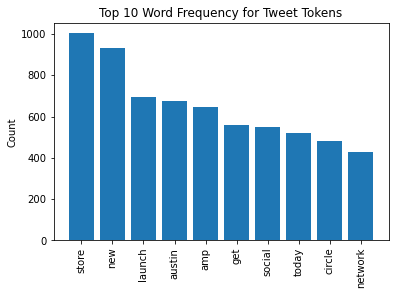

In [23]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_10(freq_dist, "Top 10 Word Frequency for Tweet Tokens")

In [24]:
processed_df['string_tokens'] = processed_df['tweet_tokens'].apply(" ".join)

/var/folders/q_/g2zssbt10h1blxnpvcp374lw0000gn/T/ipykernel_96014/357343184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['string_tokens'] = processed_df['tweet_tokens'].apply(" ".join)


In [25]:
pd.to_pickle(processed_df, './processed_df.pkl')

In [26]:
X = processed_df['string_tokens']
y = processed_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
vectorizer = TfidfVectorizer(min_df= 0.05, max_df = 0.95)

X_train_vect = vectorizer.fit_transform(X_train)

X_test_vect = vectorizer.transform(X_test)

In [28]:
# from nltk import ngrams

# processed_df['ngrams'] = processed_df['string_tokens'].apply(lambda x: ngrams(x.split(), 2))

In [29]:
pos_df = processed_df[processed_df['sentiment'] == 2]

neg_df = processed_df[processed_df['sentiment'] == 0]

In [30]:
pos_tokens = []

for row in pos_df['tweet_tokens']:
    for token in row:
        pos_tokens.append(token)

pos_freq_dist = FreqDist(pos_tokens)

pos_freq_dist.most_common(10)

[('store', 415),
 ('new', 307),
 ('get', 235),
 ('austin', 212),
 ('launch', 173),
 ('amp', 171),
 ('go', 155),
 ('open', 142),
 ('come', 125),
 ('great', 118)]

In [31]:
neg_tokens = []

for row in neg_df['tweet_tokens']:
    for token in row:
        neg_tokens.append(token)

neg_freq_dist = FreqDist(neg_tokens)

neg_freq_dist.most_common(10)

[('new', 41),
 ('get', 37),
 ('need', 34),
 ('store', 34),
 ('people', 27),
 ('go', 26),
 ('circle', 25),
 ('think', 25),
 ('launch', 24),
 ('social', 23)]

In [32]:
neg_tokens_string = ' '.join(neg_tokens)
pos_tokens_string = ' '.join(pos_tokens)

In [33]:
from wordcloud import WordCloud, STOPWORDS

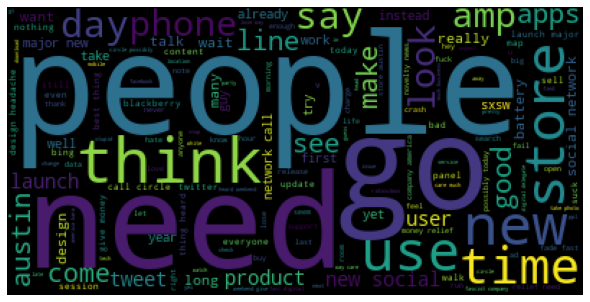

In [34]:
wordcloud = WordCloud().generate(neg_tokens_string)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

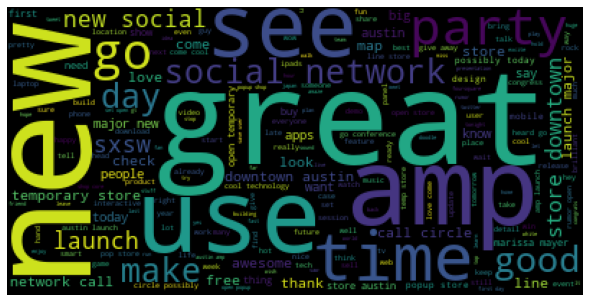

In [35]:

wordcloud = WordCloud().generate(pos_tokens_string)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [36]:

# #Calculating Negative, Positive, Neutral and Compound values
# processed_df[['polarity', 'subjectivity']] = processed_df['string_tokens'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
# for index, row in processed_df['string_tokens'].iteritems():
#  score = SentimentIntensityAnalyzer().polarity_scores(row)
#  neg = score['neg']
#  neu = score['neu']
#  pos = score['pos']
#  comp = score['compound']
#  if neg > pos:
#         processed_df.loc[index, 'sentiment'] = 'negative'
#  elif pos > neg:
#         processed_df.loc[index, 'sentiment'] = 'positive'
#  else:
#         processed_df.loc[index, 'sentiment'] = 'neutral'
#         processed_df.loc[index, 'neg'] = neg
#         processed_df.loc[index, 'neu'] = neu
#         processed_df.loc[index, 'pos'] = pos
#         processed_df.loc[index, 'compound'] = comp
#         processed_df.head(10)

In [37]:
processed_df

,tweet_tokens,sentiment,string_tokens
0,"[hrs, tweet, dead, need, upgrade, plugin, stat...",0,hrs tweet dead need upgrade plugin station
1,"[know, awesome, likely, appreciate, design, al...",2,know awesome likely appreciate design also giv...
4,"[great, stuff, fri, mayer, tim, tech, amp, mat...",2,great stuff fri mayer tim tech amp matt mullen...
7,"[start, corner, hop, skip, jump, good, time, fan]",2,start corner hop skip jump good time fan
9,"[counting, day, strong, canadian, dollar, mean...",2,counting day strong canadian dollar mean stock...
...,...,...,...
8713,"[always, use, image, stabilizer, mode, suggest...",2,always use image stabilizer mode suggestion ca...
8714,"[say, want, give, lightning, talk, audience, t...",1,say want give lightning talk audience tonight ...
8717,"[wave, buzz, interrupt, regularly, schedule, g...",1,wave buzz interrupt regularly schedule geek pr...
8718,"[zeiger, physician, never, report, potential, ...",1,zeiger physician never report potential ae yet...


In [44]:
sia = SentimentIntensityAnalyzer()

In [61]:
polarity_scores_df = processed_df['string_tokens'].apply(lambda x: sia.polarity_scores(x))

In [62]:
polarity_scores_df = pd.DataFrame(polarity_scores_df)

In [67]:
polarity_scores_df['string_tokens']

0       {'neg': 0.417, 'neu': 0.583, 'pos': 0.0, 'comp...
1       {'neg': 0.0, 'neu': 0.331, 'pos': 0.669, 'comp...
4       {'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'comp...
7       {'neg': 0.0, 'neu': 0.536, 'pos': 0.464, 'comp...
9       {'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compou...
                              ...                        
8713    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
8714    {'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...
8717    {'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...
8718    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
8719    {'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp...
Name: string_tokens, Length: 6101, dtype: object

In [73]:
print(polarity_scores_df['string_tokens'].iloc[0])

{'neg': 0.417, 'neu': 0.583, 'pos': 0.0, 'compound': -0.6486}


In [83]:
polarity_scores_df['neg'] = polarity_scores_df['string_tokens'].apply(lambda x: x['neg'])
polarity_scores_df['neu'] = polarity_scores_df['string_tokens'].apply(lambda x: x['neu'])
polarity_scores_df['pos'] = polarity_scores_df['string_tokens'].apply(lambda x: x['pos'])
polarity_scores_df['compound'] = polarity_scores_df['string_tokens'].apply(lambda x: x['compound'])

In [86]:
polarity_scores_df = polarity_scores_df.drop(columns = 'string_tokens')

In [87]:
polarity_scores_df

,neg,neu,pos,compound
0,0.417,0.583,0.000,-0.6486
1,0.000,0.331,0.669,0.8779
4,0.000,0.687,0.313,0.6249
7,0.000,0.536,0.464,0.6369
9,0.000,0.680,0.320,0.5106
...,...,...,...,...
8713,0.000,1.000,0.000,0.0000
8714,0.000,0.874,0.126,0.0772
8717,0.375,0.625,0.000,-0.4939
8718,0.000,1.000,0.000,0.0000


In [93]:
processed_df = processed_df.join(polarity_scores_df)

In [94]:
processed_df[processed_df['neg'] > 0.6]

,tweet_tokens,sentiment,string_tokens,neg,neu,pos,compound
1043,"[danger, sit, floor, charge, laptop, ipod, etc...",1,danger sit floor charge laptop ipod etc dread ...,0.626,0.374,0.000,-0.9246
1691,"[disaster, die, middle, function, head, store]",0,disaster die middle function head store,0.667,0.333,0.000,-0.8402
1759,"[really, bad, person, steal, guy, say]",2,really bad person steal guy say,0.645,0.355,0.000,-0.8051
2364,"[annoyed, schedule, bad, finger, ai, fat]",0,annoyed schedule bad finger ai fat,0.604,0.396,0.000,-0.7269
3325,"[rip, june, survive, severe, drop, evade, drown]",0,rip june survive severe drop evade drown,0.677,0.323,0.000,-0.8126
4044,"[desperately, charge, station, spot, die]",1,desperately charge station spot die,0.684,0.316,0.000,-0.7579
6947,"[twitter, fail, last, time, force, choke]",0,twitter fail last time force choke,0.636,0.364,0.000,-0.7906
8323,"[ungrateful, bc, much, shit, play, turn, shit]",0,ungrateful bc much shit play turn shit,0.654,0.192,0.154,-0.8316


In [137]:
feature_df = df.drop(columns = ['tweet_text', 'emotion', 'tweet_tokens', 'string_tokens', 'punct_count'])

In [138]:
feature_df

,sentiment,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
0,0,127,23,5,15,4,0,7,21,0,1,5.521739,4.600000,0.913043,0.304348
1,2,139,22,3,10,1,0,7,22,0,0,6.318182,7.333333,1.000000,0.318182
4,2,131,17,1,14,1,0,1,17,0,0,7.705882,17.000000,1.000000,0.058824
7,2,138,28,1,8,2,0,15,24,0,0,4.928571,28.000000,0.857143,0.535714
9,2,88,16,1,3,0,0,5,16,0,0,5.500000,16.000000,1.000000,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8713,2,137,25,3,13,1,0,8,23,0,0,5.480000,8.333333,0.920000,0.320000
8714,1,140,24,2,7,1,0,8,21,0,0,5.833333,12.000000,0.875000,0.333333
8717,1,125,18,1,4,1,0,2,18,0,0,6.944444,18.000000,1.000000,0.111111
8718,1,145,19,3,9,2,0,2,19,0,0,7.631579,6.333333,1.000000,0.105263


<AxesSubplot:>

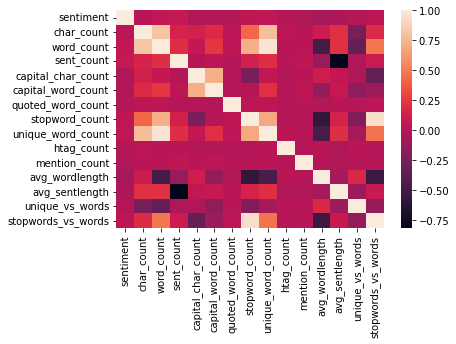

In [140]:
sns.heatmap(feature_df.corr())